In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import ttest_rel, wilcoxon
import seaborn as sns
import mne

In [48]:
sudoku1 = pd.read_csv("sudoku1.csv", delimiter="\t", header=None)
sudoku2 = pd.read_csv("sudoku2.csv", delimiter="\t", header=None)

# Select only EEG channels (columns 1 to 8)
eeg_channels = list(range(1, 9))
sudoku1_eeg = sudoku1.iloc[:, eeg_channels]
sudoku2_eeg = sudoku2.iloc[:, eeg_channels]

sudoku1_eeg = sudoku1_eeg.apply(pd.to_numeric)
sudoku2_eeg = sudoku2_eeg.apply(pd.to_numeric)

print(sudoku1_eeg.head())
print(sudoku2_eeg.head())

             1             2             3             4             5  \
0     0.000000      0.000000      0.000000      0.000000      0.000000   
1  8913.562764  17400.631893  23271.362277  20163.173397  24611.349358   
2  8040.235405  16512.999417  22380.265281  19266.846093  23718.508925   
3  6743.811875  15223.259058  21090.748440  17974.468228  22431.271962   
4  7412.531365  15905.166078  21768.945070  18651.234347  23118.118717   

              6             7             8  
0      0.000000      0.000000      0.000000  
1  11486.784993  19364.746733  14552.572614  
2  10587.261389  18475.370821  13660.022755  
3   9301.432586  17191.084288  12371.064707  
4   9999.812841  17878.579244  13050.982422  
              1             2             3             4             5  \
0      0.000000      0.000000      0.000000      0.000000      0.000000   
1  42721.783247  52654.205579  55896.057891  53493.692397  57934.358172   
2  41551.356501  51484.672902  54724.535909  52322.729

In [49]:
def baseline_normalize(eeg_data, baseline_samples=250):  # 250 samples = 1 second if fs=250
    baseline_mean = eeg_data.iloc[:baseline_samples, :].mean()
    normalized_eeg = eeg_data - baseline_mean
    return normalized_eeg

In [50]:
#Apply baseline normalization before filtering
sudoku1_eeg = baseline_normalize(sudoku1_eeg, baseline_samples=250)  #normalize on first 1 sec
sudoku2_eeg = baseline_normalize(sudoku2_eeg, baseline_samples=250)

In [51]:
# Sampling rate
fs = 250  # Hz (samples per second)

# Extract timestamp column (column 22 based on Cassia's email)
sudoku1_timestamps = sudoku1.iloc[:, 22]
sudoku2_timestamps = sudoku2.iloc[:, 22]

# Verify timestamp consistency
sudoku1_time_diff = np.diff(sudoku1_timestamps)
sudoku2_time_diff = np.diff(sudoku2_timestamps)

if not np.isclose(np.mean(sudoku1_time_diff), 1/fs, atol=1e-4):
    sudoku1_time_fixed = np.arange(len(sudoku1_eeg)) / fs
else:
    sudoku1_time_fixed = sudoku1_timestamps - sudoku1_timestamps.iloc[0]

if not np.isclose(np.mean(sudoku2_time_diff), 1/fs, atol=1e-4):
    sudoku2_time_fixed = np.arange(len(sudoku2_eeg)) / fs
else:
    sudoku2_time_fixed = sudoku2_timestamps - sudoku2_timestamps.iloc[0]

In [52]:
# Bandpass filter function
def bandpass_filter(data, lowcut=0.1, highcut=30, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

sudoku1_filtered = bandpass_filter(sudoku1_eeg, lowcut=0.1, highcut=30, fs=250)
sudoku2_filtered = bandpass_filter(sudoku2_eeg, lowcut=0.1, highcut=30, fs=250)

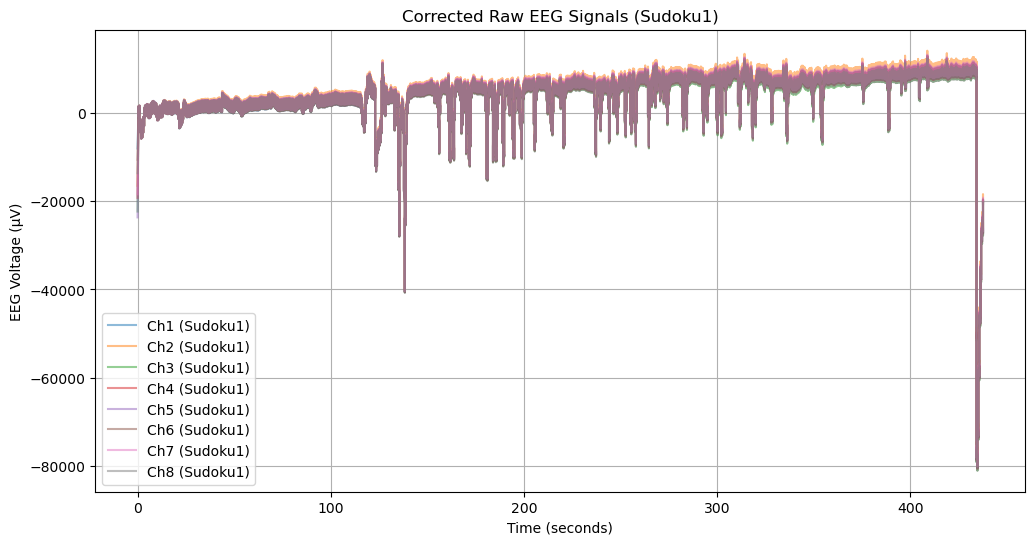

In [53]:
# Raw EEG signals for sudoku1
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku1_time_fixed, sudoku1_eeg.iloc[:, i], label=f"Ch{i+1} (Sudoku1)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Corrected Raw EEG Signals (Sudoku1)")
plt.legend()
plt.grid()
plt.show()

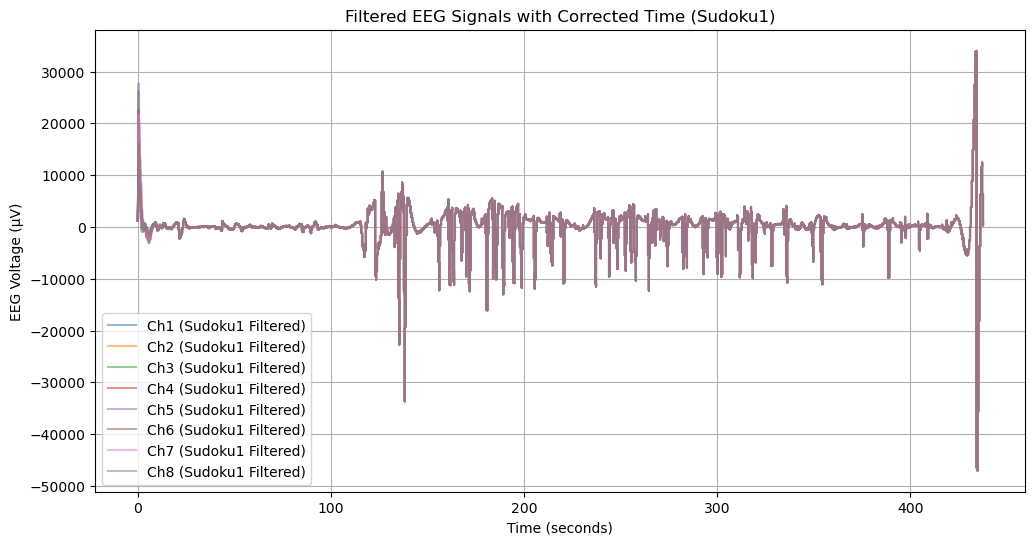

In [54]:
# Filtered EEG signals for sudoku1
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku1_time_fixed, sudoku1_filtered[:, i], label=f"Ch{i+1} (Sudoku1 Filtered)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Filtered EEG Signals with Corrected Time (Sudoku1)")
plt.legend()
plt.grid()
plt.show()

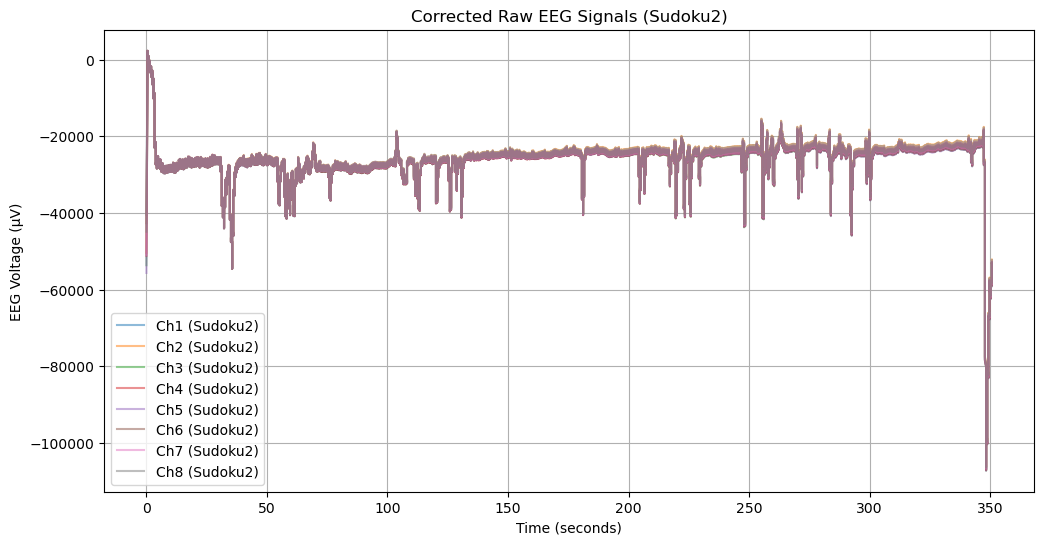

In [55]:
# Raw EEG Signals for Sudoku2
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku2_time_fixed, sudoku2_eeg.iloc[:, i], label=f"Ch{i+1} (Sudoku2)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Corrected Raw EEG Signals (Sudoku2)")
plt.legend()
plt.grid()
plt.show()

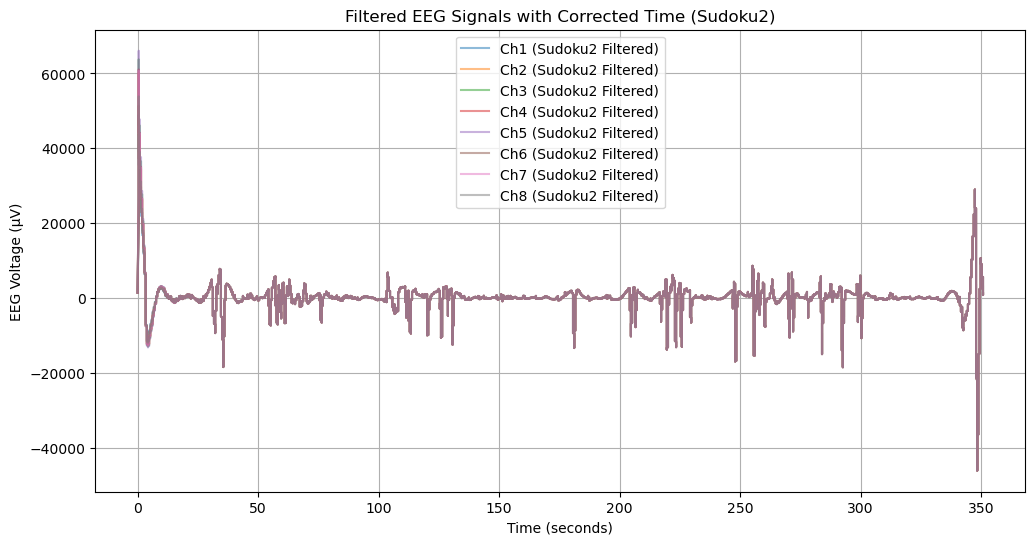

In [56]:
# Filtered EEG Signals for Sudoku2
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku2_time_fixed, sudoku2_filtered[:, i], label=f"Ch{i+1} (Sudoku2 Filtered)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Filtered EEG Signals with Corrected Time (Sudoku2)")
plt.legend()
plt.grid()
plt.show()

In [57]:
# Compute and Plot EEG Power Changes Between Sudoku1 and Sudoku2
bands = {"Delta": (0.5, 4), "Theta": (4, 8), "Alpha": (8, 12), "Beta": (12, 30)}
psd_values = {}
for band, (low, high) in bands.items():
    psd_values[band] = {}
    for i in range(8):
        freqs, psd1 = welch(sudoku1_filtered[:, i], fs=250, nperseg=250*2)
        freqs, psd2 = welch(sudoku2_filtered[:, i], fs=250, nperseg=250*2)
        band_idx = np.where((freqs >= low) & (freqs <= high))
        psd_values[band][f"Ch{i+1}"] = np.mean(psd2[band_idx]) - np.mean(psd1[band_idx])

psd_df = pd.DataFrame(psd_values)

<Figure size 800x500 with 0 Axes>

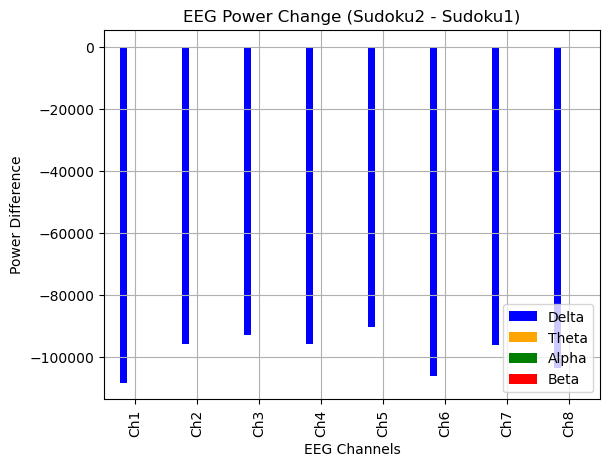

In [58]:
# EEG Power Differences Between Sudoku1 and Sudoku2
plt.figure(figsize=(8, 5))
psd_df.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("EEG Channels")
plt.ylabel("Power Difference")
plt.title("EEG Power Change (Sudoku2 - Sudoku1)")
plt.legend(["Delta", "Theta", "Alpha", "Beta"])
plt.grid()
plt.show()

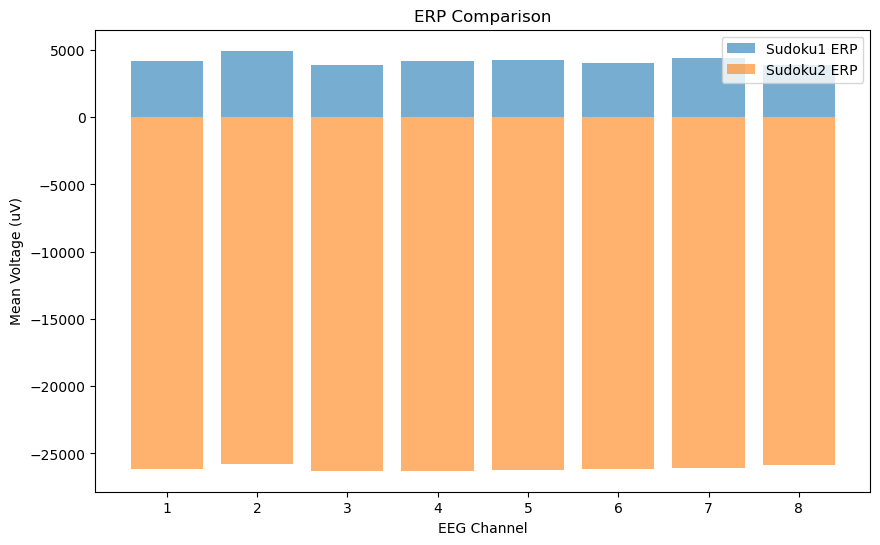

In [71]:
# Compute ERP (mean across time per channel)
sudoku1_erp = sudoku1_eeg.mean(axis=0)
sudoku2_erp = sudoku2_eeg.mean(axis=0)

# Plot ERP for comparison
plt.figure(figsize=(10, 6))
plt.bar(range(1, 9), sudoku1_erp, alpha=0.6, label="Sudoku1 ERP")
plt.bar(range(1, 9), sudoku2_erp, alpha=0.6, label="Sudoku2 ERP")
plt.xlabel("EEG Channel")
plt.ylabel("Mean Voltage (uV)")
plt.title("ERP Comparison")
plt.legend()
plt.show()


In [63]:
def create_topomap(data):
  fs = 500
  n_channels = 8

  info = mne.create_info(ch_names=[f"Ch{i+1}" for i in range(n_channels)], sfreq=fs, ch_types='eeg')

  raw_array = mne.io.RawArray(data.values.reshape(n_channels, 1), info)

  channel_mapping = {
      'Ch1': 'Fz',
      'Ch2': 'C3',
      'Ch3': 'Pz',
      'Ch4': 'P4',
      'Ch5': 'F7',
      'Ch6': 'F4',
      'Ch7': 'F8',
      'Ch8': 'P3'
  }
  raw_array.rename_channels(channel_mapping)

  #Set standard 10-20 montage
  raw_array.set_montage('standard_1020')

  #Create Evoked object for topomap plotting (average of the "ERP")
  evoked = mne.EvokedArray(raw_array.get_data(), raw_array.info)

  #Plot the topomap
  fig, ax = plt.subplots(figsize=(6, 4))
  mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, show=True)
  plt.show()



Creating RawArray with float64 data, n_channels=8, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


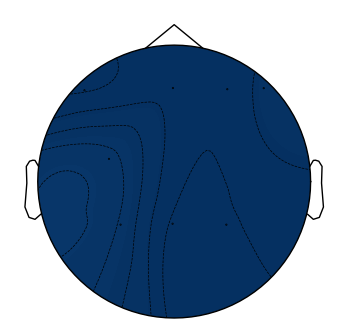

Creating RawArray with float64 data, n_channels=8, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


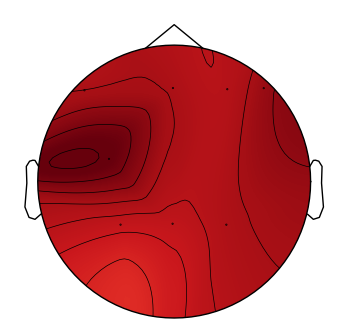

In [64]:
create_topomap(sudoku2_erp)
create_topomap(sudoku1_erp)

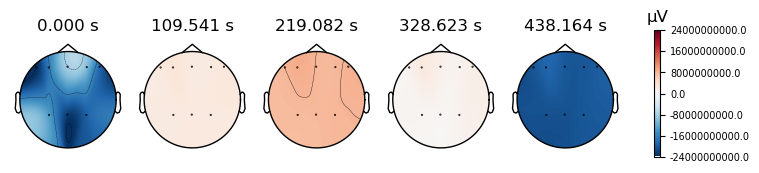

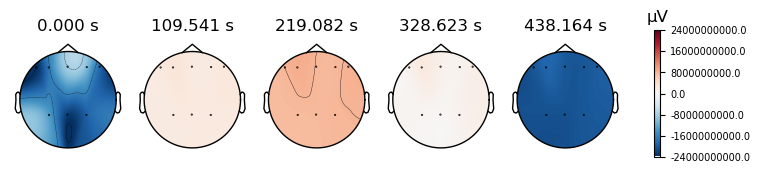

In [73]:
# Define standard 10-20 channel names
standard_channels = ["Fz", "F3", "Pz", "P4", "F7", "F4", "F8", "P3"]

# Create MNE info structure
fs = 250  # Hz (sampling rate)
info = mne.create_info(ch_names=standard_channels, sfreq=fs, ch_types="eeg")
montage = mne.channels.make_standard_montage("standard_1020")
info.set_montage(montage)

# Create a time axis for EvokedArray
n_times = sudoku1_eeg.shape[0]  # Number of time points in the dataset
times = np.arange(n_times) / fs  # Create time array matching sampling rate

# Create evoked object from EEG data
data = sudoku1_eeg.T.values  # Transpose to match (n_channels, n_times)
evoked = mne.EvokedArray(data, info, tmin=times[0])

# Define time points for topomap visualization
topomap_times = np.linspace(times[0], times[-1], num=5)  # Select 5 evenly spaced time points

# Plot topomap
evoked.plot_topomap(times=topomap_times, ch_type="eeg")